### Regression with Neural Networks

In [5]:
import pandas as pd
import numpy as np

In [6]:
# load dataset
df = pd.read_csv('kc_house_data.csv')
df.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639


Clean dataset

In [7]:
# fix current datetime format
df['date'] = pd.to_datetime(df.date)

# create separate column to indicate how many days from today since sale to output some numerical value
def calculate_days(date):
    today = pd.Timestamp('today')
    return (today - date)

df['days'] = df['date'].apply(lambda x: calculate_days(x)).dt.days
df.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,days
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2734
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2677


In [8]:
# create separate column of year sold to calculate differences of year built and year renovated
df['year_sold'] = pd.DatetimeIndex(df['date']).year
df.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,days,year_sold
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,0,1955,0,98178,47.5112,-122.257,1340,5650,2734,2014
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,2677,2014


In [9]:
# yr_renovated = 0 actually means not renovated, but model would interpret this as renovated in year 0. Need to change 0 to year built of same row. 

df['yr_renovated'] = df.apply(lambda x: x['yr_built'] if x['yr_renovated']==0 else x['yr_renovated'], axis=1)
df['after_renovation'] = df['year_sold'] - df['yr_renovated'] # indicates the number of years after renovation the house was sold
df['after_built'] = df['year_sold'] - df['yr_built'] # indicates the number of years after original build the house was sold
df.head(2)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,days,year_sold,after_renovation,after_built
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,1955,98178,47.5112,-122.257,1340,5650,2734,2014,59,59
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,1991,98125,47.7210,-122.319,1690,7639,2677,2014,23,63


In [10]:
df_cols = []
for col in df.columns:
    df_cols.append(col)
print(df_cols)

['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'days', 'year_sold', 'after_renovation', 'after_built']


In [11]:
# clean and scale dataset

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
categorical_cols = ['waterfront', 'view', 'zipcode'] # one-hot encode these columns
drop_cols = ['id', 'date', 'lat', 'long', 'yr_built', 'yr_renovated', 'year_sold'] # drop features
scale_cols = ['price','bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'days', 'after_renovation', 'after_built']

df_1 = pd.get_dummies(df, columns = categorical_cols)
df_1 = df_1.drop(drop_cols, axis = 1)
df_1[scale_cols] = scaler.fit_transform(df_1[scale_cols])
df_1.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,-0.866717,-0.398737,-1.447464,-0.979835,-0.228321,-0.915427,-0.629187,-0.558836,-0.734708,-0.658681,...,0,0,0,0,0,0,1,0,0,0
1,-0.005688,-0.398737,0.175607,0.533634,-0.189885,0.936506,-0.629187,-0.558836,0.460841,0.245141,...,0,0,0,0,0,0,0,0,0,0
2,-0.980849,-1.473959,-1.447464,-1.426254,-0.123298,-0.915427,-0.629187,-1.409587,-1.229834,-0.658681,...,0,0,0,0,0,0,0,0,0,0
3,0.174090,0.676485,1.149449,-0.130550,-0.244014,-0.915427,2.444294,-0.558836,-0.891699,1.397515,...,0,0,0,0,0,0,0,0,0,0
4,-0.081958,-0.398737,-0.149007,-0.435422,-0.169653,-0.915427,-0.629187,0.291916,-0.130895,-0.658681,...,0,0,0,0,0,0,0,0,0,0


#### Hyperparameter Tuning
Determine best combination of hyperparameters

In [12]:
pip install talos &> /dev/null

In [13]:
# import libraries for our model
import tensorflow as tf
import talos
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from talos.model.normalizers import lr_normalizer
from tensorflow.keras.optimizers import Adam,RMSprop

In [14]:
# test parameters to determine best combination

hp = {    
    'lr':[10**-1, 10**-2, 10**-3],
    'neurons': [1, 8, 55],
    'hidden_layers': [1, 2, 3],
    'batch_size': [10, 100],
    'epochs': [10, 50],
    'optimizer': [Adam, RMSprop],
    'loss': ['mean_squared_error'],
    'activation': ['sigmoid', 'relu', 'tanh']
    }

In [15]:
# create mirroring testing function of parameters 

def test_params(x_train, y_train, x_val, y_val, params):
  model = tf.keras.Sequential()

  model.add(tf.keras.Input(shape=(x_train.shape[1], )))

  model.add(tf.keras.layers.Dense(params['neurons'], activation=params['activation']))

  model.add(tf.keras.layers.Dense(1, activation='linear'))

  model.compile(loss=params['loss'],
                optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer']))
                )

  out = model.fit(x_train, y_train,
                  batch_size=params['batch_size'],
                  epochs=params['epochs'],
                  validation_data=[x_val, y_val])
  
  return out, model

Talos process commented out due to time and resource constraints

In [16]:
# scan_object = talos.Scan(X, y, model=test_params, params=hp, experiment_name='best_params')

In [17]:
# # display results
# scan_object.data

In [18]:
# # sort results of talos to display best parameters
# best_params = scan_object.data.sort_values("val_loss")
# best_params.head(3)

In [19]:
# # worst parameters for comparison
# best_params.tail(3)

In [20]:
# best_hp = best_params.head(3)
# worst_hp = best_params.tail(3)
# combined_params = best_hp.append(worst_hp, ignore_index = True)
# combined_dict = {}
# for i in range(len(combined_params)):
#   combined_dict[i+1] = combined_params.iloc[i].to_dict()

# # OR

# combined_hp = {list param values in sequential order to pass all at once}
combined_dict = {
    1: {'activation': 'relu',
  'batch_size': 10,
  'duration': 110.52254700660706,
  'end': '04/08/22-005810',
  'epochs': 30,
  'hidden_layers': 1,
  'loss': 'mean_squared_error',
  'lr': 0.1,
  'neurons': 55,
  'optimizer': Adam,
  'round_epochs': 30,
  'start': '04/08/22-005619',
  'val_loss': 0.11350148916244507},
  2: {'activation': 'relu',
  'batch_size': 10,
  'duration': 142.30464148521423,
  'end': '04/08/22-012329',
  'epochs': 30,
  'hidden_layers': 3,
  'loss': 'mean_squared_error',
  'lr': 0.1,
  'neurons': 55,
  'optimizer': Adam,
  'round_epochs': 30,
  'start': '04/08/22-012107',
  'val_loss': 0.11466764658689499},
 3: {'activation': 'relu',
  'batch_size': 10,
  'duration': 103.79812622070312,
  'end': '04/08/22-012513',
  'epochs': 30,
  'hidden_layers': 3,
  'loss': 'mean_squared_error',
  'lr': 0.1,
  'neurons': 55,
  'optimizer': RMSprop,
  'round_epochs': 30,
  'start': '04/08/22-012329',
  'val_loss': 0.11820962280035019},
 4: {'activation': 'sigmoid',
  'batch_size': 100,
  'duration': 4.534484624862671,
  'end': '04/08/22-002636',
  'epochs': 10,
  'hidden_layers': 3,
  'loss': 'mean_squared_error',
  'lr': 0.001,
  'neurons': 8,
  'optimizer': Adam,
  'round_epochs': 10,
  'start': '04/08/22-002631',
  'val_loss': 2.4169609546661377},
 5: {'activation': 'sigmoid',
  'batch_size': 10,
  'duration': 33.75606298446655,
  'end': '04/07/22-232614',
  'epochs': 10,
  'hidden_layers': 1,
  'loss': 'mean_squared_error',
  'lr': 0.001,
  'neurons': 8,
  'optimizer': Adam,
  'round_epochs': 10,
  'start': '04/07/22-232541',
  'val_loss': 3.052388906478882},
 6: {'activation': 'sigmoid',
  'batch_size': 10,
  'duration': 142.3119673728943,
  'end': '04/07/22-235400',
  'epochs': 30,
  'hidden_layers': 1,
  'loss': 'mean_squared_error',
  'lr': 0.001,
  'neurons': 8,
  'optimizer': Adam,
  'round_epochs': 30,
  'start': '04/07/22-235138',
  'val_loss': 3.1329691410064697}
  }

Tensorflow Sequential

In [21]:
# final function to output results of best and worst params

def predict(dataframe, parameters):
  # determine features and labels
  X = df_1.drop('price', axis = 1)
  y = df_1['price']
  X = X.to_numpy()
  y = y.to_numpy()

  # Should we include a random.shuffle function to the dataset? 

  # split dataset for train/test
  X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state = 1)

  # import keras sequential model
  model = tf.keras.Sequential()

  # input neuron of length n, where n = # of features
  model.add(tf.keras.Input(shape=(X.shape[1],)))

  # add hidden layer as defined by defined parameters
  for i in range(parameters['hidden_layers']):

    model.add(tf.keras.layers.Dense(parameters['neurons'], activation=parameters['activation']))

  # final output node
  model.add(tf.keras.layers.Dense(1, activation = 'linear'))

  # define optimizer and loss function 
  model.compile(loss=parameters['loss'],
                  optimizer=parameters['optimizer'](lr=lr_normalizer(parameters['lr'], parameters['optimizer']))
                  )
  # define batch size and # of epochs
  model.fit(X_train_1, y_train_1, batch_size = parameters['batch_size'], epochs = parameters['epochs'], verbose=1, validation_split=0.2)

  # predict using model
  pred_train = model.predict(X_train_1)

  pred = model.predict(X_test_1)

  # output the MSE of the predictions
  output = np.sqrt(mean_squared_error(y_test_1, pred))

  return output


Comparison of results using Linear Regression

In [22]:
from sklearn.linear_model import LinearRegression

def linear(dataset):

  X = dataset.drop('price', axis = 1)
  y = dataset['price']
  X = X.to_numpy()
  y = y.to_numpy()

  X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state = 1)

  model = LinearRegression()

  model.fit(X_train_1, y_train_1)

  model_score = model.score(X_train_1, y_train_1)

  prediction = model.predict(X_test_1)

  MSE = np.mean((prediction-y_test_1)**2)

  coef = model.coef_

  intercept = model.intercept_

  return print('The model score is:', model_score, '\n'), print('The mean squared error is:', MSE, '\n'), print('Coef:', coef, '\n', 'Intercept:', intercept, '\n')


In [23]:
linear(df_1)

The model score is: 0.8203610411159351 

The mean squared error is: 0.28107077318474344 

Coef: [-5.97435347e-02  4.12408862e-02  7.41892278e+11  2.69529223e-02
 -5.73944082e-02  4.60649016e-02  1.85498719e-01 -6.68910002e+11
 -3.57500420e+11  2.00421646e-02 -8.14540150e-03 -3.57200484e-02
 -4.19478936e-02  9.71632499e-02  1.26228369e+10  1.26228369e+10
  4.60189836e+10  4.60189836e+10  4.60189836e+10  4.60189836e+10
  4.60189836e+10 -3.50781229e+09 -3.50781229e+09 -3.50781229e+09
 -3.50781229e+09 -3.50781229e+09 -3.50781229e+09 -3.50781229e+09
 -3.50781229e+09 -3.50781229e+09 -3.50781229e+09 -3.50781229e+09
 -3.50781229e+09 -3.50781229e+09 -3.50781229e+09 -3.50781229e+09
 -3.50781229e+09 -3.50781229e+09 -3.50781229e+09 -3.50781229e+09
 -3.50781229e+09 -3.50781229e+09 -3.50781229e+09 -3.50781229e+09
 -3.50781229e+09 -3.50781229e+09 -3.50781229e+09 -3.50781229e+09
 -3.50781229e+09 -3.50781229e+09 -3.50781229e+09 -3.50781229e+09
 -3.50781229e+09 -3.50781229e+09 -3.50781229e+09 -3.5078122

(None, None, None)

In [24]:
# running this function on all six is for plotting purposes and will take time to display results of the six combinations of parameters defined
# for convenience, an example of the results for combined_dict is shown below

import matplotlib.pyplot as plt

def results(combined_dict):
  x = []
  y = []
  for key, value in combined_dict.items():
    x.append(key)
    output = predict(df_1, value)
    y.append(output)

  plt.figure(figsize=(8,6))
  plt.scatter(x,y)
  plt.title('Overall Scores')
  plt.xlabel('Ranked Parameters')
  plt.ylabel('Mean Squred Error')
  plt.show()
  # return print('x values:', x), print('y values:', y)


Epoch 1/30
1384/1384 [==============================] - 4s 2ms/step - loss: 0.4261 - val_loss: 0.3263
Epoch 2/30
1384/1384 [==============================] - 6s 4ms/step - loss: 0.2500 - val_loss: 0.2613
Epoch 3/30
1384/1384 [==============================] - 7s 5ms/step - loss: 0.2042 - val_loss: 0.2255
Epoch 4/30
1384/1384 [==============================] - 7s 5ms/step - loss: 0.1767 - val_loss: 0.1983
Epoch 5/30
1384/1384 [==============================] - 6s 5ms/step - loss: 0.1591 - val_loss: 0.1818
Epoch 6/30
1384/1384 [==============================] - 6s 4ms/step - loss: 0.1469 - val_loss: 0.1703
Epoch 7/30
1384/1384 [==============================] - 3s 2ms/step - loss: 0.1373 - val_loss: 0.1614
Epoch 8/30
1384/1384 [==============================] - 3s 2ms/step - loss: 0.1307 - val_loss: 0.1559
Epoch 9/30
1384/1384 [==============================] - 3s 2ms/step - loss: 0.1257 - val_loss: 0.1499
Epoch 10/30
1384/1384 [==============================] - 3s 2ms/step - loss: 0.121

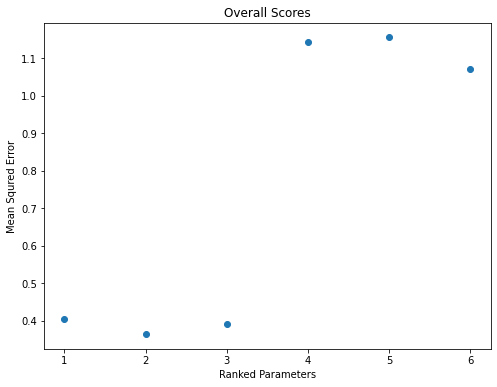

x values: [1, 2, 3, 4, 5, 6]
y values: [0.405328211591009, 0.3651176157292192, 0.3918473176418445, 1.1416269064235538, 1.154971877988932, 1.0696971340340236]


(None, None)

In [25]:
results(combined_dict)